In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn import set_config
set_config(transform_output="pandas")

import missingno as msno 

# Set random seed 
RSEED = 42


## <a id='2'>Loading and cleaning the data</a>

In [2]:
df= pd.read_csv('data/archive/HAM10000_metadata.csv')

df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB



Creating dictionary for displaying more userfriendly labels:

In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = 'data/archive'



Merging images from both folders into one dictionary:

In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}


Creating new columns for better understanding of features:

In [6]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,data/archive\HAM10000_images_part_1\ISIC_00274...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,data/archive\HAM10000_images_part_1\ISIC_00250...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,data/archive\HAM10000_images_part_1\ISIC_00267...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,data/archive\HAM10000_images_part_1\ISIC_00256...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,data/archive\HAM10000_images_part_2\ISIC_00316...,Benign keratosis-like lesions,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


### Data cleaning:

In [8]:
df.duplicated().value_counts()

False    10015
Name: count, dtype: int64

No duplicated rows

In [9]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

Checking distribution of 'age' column with histogram:

<Axes: xlabel='age', ylabel='Count'>

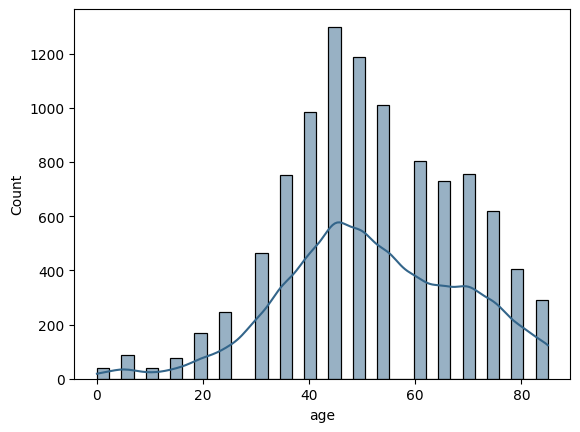

In [10]:
sns.histplot(df['age'], kde=True, color='#33658A')

'age' data is skewed with significantly more higher values, therefore the missing values with be filled with the median instead of the mean:

In [11]:
hours_studied_median = df['age'].median()
df['age'].fillna(hours_studied_median, inplace=True)

In [12]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

# <a id='3'>Part 1: Exploratory Data Analysis (EDA)</a>

1.1 Age dependencies:

# <a id='4'>Part 2: Model creation</a>

Resizing images and saving them as numpy array in new 'image' column:

In [13]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [14]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.30,random_state=42)

In [16]:
x_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
2399,HAM_0004542,ISIC_0027256,vasc,consensus,0.0,female,back,data/archive\HAM10000_images_part_1\ISIC_00272...,Vascular lesions,"[[[201, 182, 205], [201, 181, 206], [201, 182,..."
8246,HAM_0001872,ISIC_0029188,nv,histo,60.0,female,lower extremity,data/archive\HAM10000_images_part_1\ISIC_00291...,Melanocytic nevi,"[[[251, 200, 245], [254, 203, 252], [253, 203,..."
8052,HAM_0000897,ISIC_0029306,nv,histo,35.0,female,acral,data/archive\HAM10000_images_part_2\ISIC_00293...,Melanocytic nevi,"[[[188, 148, 140], [192, 151, 144], [191, 150,..."
5840,HAM_0006639,ISIC_0028733,nv,follow_up,45.0,male,lower extremity,data/archive\HAM10000_images_part_1\ISIC_00287...,Melanocytic nevi,"[[[240, 154, 172], [241, 155, 173], [243, 157,..."
3540,HAM_0007469,ISIC_0030049,nv,follow_up,35.0,female,trunk,data/archive\HAM10000_images_part_2\ISIC_00300...,Melanocytic nevi,"[[[231, 172, 173], [234, 175, 177], [236, 176,..."


Normalization of images:

In [17]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

One hot encoding of target feature:

In [18]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

Further splitting of train data into training and validation set:

In [19]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [20]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

Data augmentation to prevent overfitting:

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)



CNN model creation:

In [22]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [23]:
# Compile the model
model.compile(optimizer = tf.keras.optimizers.legacy.Adam() , loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            learning_rate=0.00001)

Fitting the model:

In [24]:
epochs = 50
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50


C:\Users\49176\AppData\Local\Temp\ipykernel_20932\4200995115.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


630/630 [==============================] - 168s 266ms/step - loss: 0.2502 - accuracy: 0.6611 - val_loss: 0.2186 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 2/50
630/630 [==============================] - 167s 265ms/step - loss: 0.2193 - accuracy: 0.6790 - val_loss: 0.2073 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 3/50
630/630 [==============================] - 166s 263ms/step - loss: 0.2140 - accuracy: 0.6817 - val_loss: 0.2005 - val_accuracy: 0.6676 - lr: 0.0010
Epoch 4/50
630/630 [==============================] - 165s 261ms/step - loss: 0.2051 - accuracy: 0.6874 - val_loss: 0.1951 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 5/50
630/630 [==============================] - 166s 264ms/step - loss: 0.2026 - accuracy: 0.6920 - val_loss: 0.1892 - val_accuracy: 0.6919 - lr: 0.0010
Epoch 6/50
630/630 [==============================] - 165s 261ms/step - loss: 0.1961 - accuracy: 0.6976 - val_loss: 0.1865 - val_accuracy: 0.7133 - lr: 0.0010
Epoch 7/50
630/630 [==============================] - 165

In [25]:
# Saving the model
import joblib
joblib.dump(model, 'model_acc_79.pkl')

['model_acc_79.pkl']

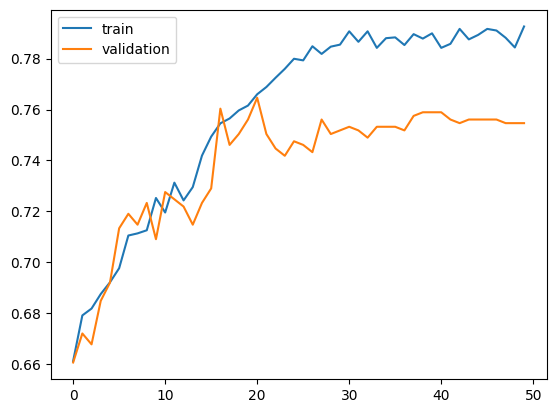

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='upper left')

Function for the evaluation of a classification with a neural network:

In [30]:
def evaluate_classification_neural_network(y_train, y_test, y_pred_train, y_pred_test):
    # Convert probabilities to binary predictions using the threshold
    threshold=0.5
    y_pred_train_binary = (y_pred_train > threshold).astype(int)
    y_pred_test_binary = (y_pred_test > threshold).astype(int)

    # Print accuracy of our model for train and test set
    print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train_binary), 2))
    print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test_binary), 2))
    print("--------" * 10)

    # Print classification report of our model for train data
    print("Classification for train data:")
    print(classification_report(y_train, y_pred_train_binary))
    print("--------" * 10)

    # Print classification report of our model for test data
    print("Classification for test data:")
    print(classification_report(y_test, y_pred_test_binary))
    print("--------" * 10)

    # Evaluate the model with a confusion matrix
    cm = confusion_matrix(y_test, y_pred_test_binary)

    # Plot smaller heatmap
    heatmap_size=(8, 6)
    fig, ax = plt.subplots(figsize=heatmap_size)
    sns.heatmap(cm, annot=True, cmap='YlOrRd',
                yticklabels=['Actual negative', 'Actual positive'],
                xticklabels=['Predicted negative', 'Predicted positive'], ax=ax)
    plt.show()

In [28]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

94/94 [==============================] - 15s 161ms/step


In [33]:
evaluate_classification_neural_network(y_train, y_test, y_pred_train, y_pred_test)

Accuracy on train set: 0.78
Accuracy on test set: 0.72
--------------------------------------------------------------------------------
Classification for train data:
              precision    recall  f1-score   support

           0       0.72      0.19      0.30       204
           1       0.75      0.54      0.62       339
           2       0.64      0.55      0.59       671
           3       0.00      0.00      0.00        65
           4       0.89      0.94      0.92      4246
           5       0.76      0.32      0.45       686
           6       0.99      0.73      0.84        98

   micro avg       0.86      0.78      0.81      6309
   macro avg       0.68      0.47      0.53      6309
weighted avg       0.83      0.78      0.79      6309
 samples avg       0.78      0.78      0.78      6309

--------------------------------------------------------------------------------
Classification for test data:
              precision    recall  f1-score   support

           0    

c:\Users\49176\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\49176\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\49176\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

ValueError: multilabel-indicator is not supported

In [40]:

loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

22/22 [==============================] - 3s 148ms/step - loss: 0.1618 - accuracy: 0.7546
Validation: accuracy = 0.754636  ;  loss_v = 0.161774
Test: accuracy = 0.756406  ;  loss = 0.162380


In [35]:
 def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix with training data:

198/198 [==============================] - 33s 165ms/step


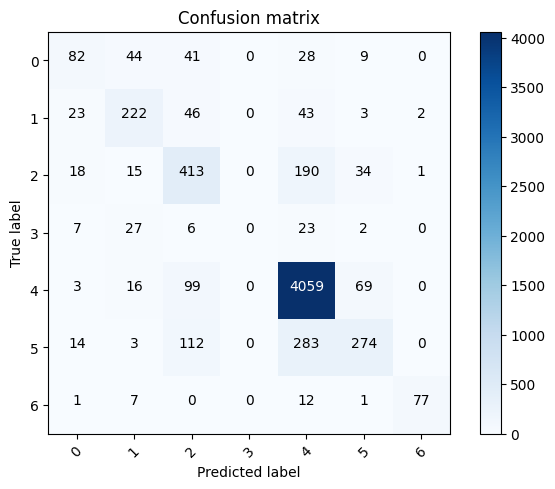

In [39]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_train)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_train,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Confusion matrix with test data:

94/94 [==============================] - 15s 157ms/step


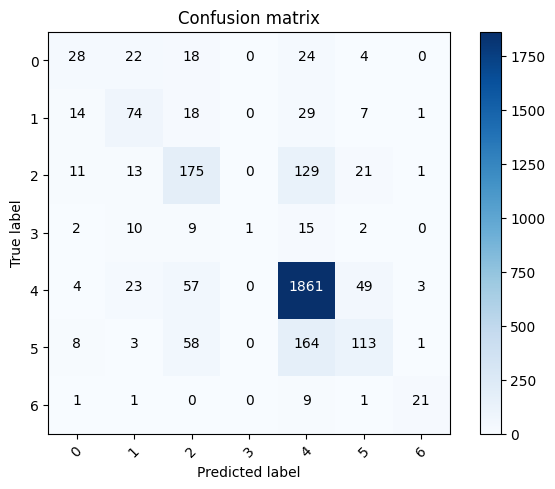

In [38]:
Y_pred = model.predict(x_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))